# PTM PPI Shortcut analysis

In [1]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")

all_labels = list(range(7))
pos_labels = list(range(1,7,1))
label_names = ["other",
                            "phosphorylation",
                            "dephosphorylation",
                            "methylation",
                            "ubiquitination",
                            "acetylation",
                            "deubiquitination"]

In [2]:
trainfile="../temp/train.json"
testfile="../temp/test.json"
valfile="../temp/val.json"
largescalefile = "../temp/markers_largescale_multiclass.json"
largescale_low_hq="../temp/markers_largescale_below_multiclass.json"

In [3]:
from model_nb_tree_classifier import ModelNBTreeClassifier
m = ModelNBTreeClassifier("PROTPART1", "PROTPART0")



In [4]:
def print_report(actual, pred, latex=True, labels=None):

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    print(sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=False,
                                            labels=labels,zero_division=0)
     )
    
    if latex:
        
        d = sklearn.metrics.classification_report(actual,
                                                pred,
                                                output_dict=True,
                                                labels=[0,1, 2, 3, 4, 5, 6],zero_division=0)
        return pd.DataFrame(d).T

In [5]:
df_train = pd.read_json(trainfile, orient="records")
m.train(df_train["x"], df_train["y"])

print_report(df_train["y"], m.predict(df_train["x"])[0], False, pos_labels)

print_report(df_train["y"], m.predict(df_train["x"])[0], False, all_labels)



              precision    recall  f1-score   support

           1       0.35      0.82      0.49       139
           2       0.21      0.79      0.34        28
           3       0.31      1.00      0.48        10
           4       0.28      1.00      0.43         5
           5       0.19      1.00      0.31         5
           6       0.50      1.00      0.67         2

   micro avg       0.31      0.84      0.45       189
   macro avg       0.31      0.93      0.45       189
weighted avg       0.33      0.84      0.47       189

              precision    recall  f1-score   support

           0       0.96      0.69      0.81      1116
           1       0.35      0.82      0.49       139
           2       0.21      0.79      0.34        28
           3       0.31      1.00      0.48        10
           4       0.28      1.00      0.43         5
           5       0.19      1.00      0.31         5
           6       0.50      1.00      0.67         2

    accuracy           

In [6]:
df_val = pd.read_json(valfile, orient="records")
print_report(df_val["y"], m.predict(df_val["x"])[0], False, pos_labels)

print_report(df_val["y"], m.predict(df_val["x"])[0], False, all_labels)




              precision    recall  f1-score   support

           1       0.36      0.76      0.48        21
           2       1.00      0.40      0.57        10
           3       0.17      1.00      0.29         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.38      0.62      0.47        34
   macro avg       0.25      0.36      0.22        34
weighted avg       0.52      0.62      0.48        34

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       166
           1       0.36      0.76      0.48        21
           2       1.00      0.40      0.57        10
           3       0.17      1.00      0.29         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.78

In [7]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(m.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]

get_top_discrimintary_keywords(m, 4)



[('protpart1', -3.36108738432399),
 ('protpart0', -3.657353200467162),
 ('prtig0', -4.4596996729921),
 ('protein', -4.4596996729921),
 ('degradation', -4.539742380665636),
 ('proteins', -4.6267537576552655),
 ('cell', -4.827424453117416),
 ('prtig1', -4.827424453117416),
 ('cells', -4.9452074887738),
 ('transcription', -4.9452074887738),
 ('dependent', -5.078738881398323),
 ('expression', -5.078738881398323),
 ('ubiquitin', -5.232889561225582),
 ('dna', -5.232889561225582),
 ('human', -5.415211118019536),
 ('ubiquitination', -5.415211118019536),
 ('depletion', -5.415211118019536),
 ('phase', -5.415211118019536),
 ('suppressor', -5.415211118019536),
 ('mediated', -5.415211118019536),
 ('activity', -5.415211118019536),
 ('response', -5.638354669333745),
 ('ligase', -5.638354669333745),
 ('cell cycle', -5.638354669333745),
 ('identify', -5.638354669333745),
 ('role', -5.638354669333745),
 ('pathway', -5.638354669333745),
 ('regulate', -5.638354669333745),
 ('results', -5.638354669333745),

In [8]:
df_test = pd.read_json(testfile, orient="records")
print_report(df_test["y"], m.predict(df_test["x"])[0], False, pos_labels)




              precision    recall  f1-score   support

           1       0.35      0.75      0.48        44
           2       0.50      0.50      0.50         6
           3       0.29      0.50      0.36         4
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

   micro avg       0.36      0.68      0.47        56
   macro avg       0.19      0.29      0.22        56
weighted avg       0.35      0.68      0.46        56



In [9]:
df_largescale_hq = pd.read_json(largescalefile, orient="records")
print_report(df_largescale_hq["y"], m.predict(df_largescale_hq["x"])[0])



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.89      0.94      5721
           2       0.31      0.64      0.42        42
           3       0.76      0.96      0.85        23
           4       0.25      0.20      0.22         5
           5       0.50      0.67      0.57         3

    accuracy                           0.89      5794
   macro avg       0.47      0.56      0.50      5794
weighted avg       0.99      0.89      0.93      5794



,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.0
1,0.997838,0.887432,0.939402,5721.0
2,0.306818,0.642857,0.415385,42.0
3,0.758621,0.956522,0.846154,23.0
4,0.250000,0.200000,0.222222,5.0
5,0.500000,0.666667,0.571429,3.0
6,0.000000,0.000000,0.000000,0.0
micro avg,0.885226,0.885226,0.885226,5794.0
macro avg,0.401897,0.479068,0.427799,5794.0
weighted avg,0.990976,0.885226,0.934424,5794.0


In [10]:
print_report(df_largescale_hq["y"], m.predict(df_largescale_hq["x"])[0], latex=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.89      0.94      5721
           2       0.31      0.64      0.42        42
           3       0.76      0.96      0.85        23
           4       0.25      0.20      0.22         5
           5       0.50      0.67      0.57         3

    accuracy                           0.89      5794
   macro avg       0.47      0.56      0.50      5794
weighted avg       0.99      0.89      0.93      5794



,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.0
1,0.997838,0.887432,0.939402,5721.0
2,0.306818,0.642857,0.415385,42.0
3,0.758621,0.956522,0.846154,23.0
4,0.250000,0.200000,0.222222,5.0
5,0.500000,0.666667,0.571429,3.0
6,0.000000,0.000000,0.000000,0.0
micro avg,0.885226,0.885226,0.885226,5794.0
macro avg,0.401897,0.479068,0.427799,5794.0
weighted avg,0.990976,0.885226,0.934424,5794.0


In [11]:
df_low_quality = pd.read_json(largescale_low_hq, orient="records",  dtype={"x":str, "y":int})

['phosphorylation', 'dephosphorylation', 'methylation', 'ubiquitination', 'acetylation']


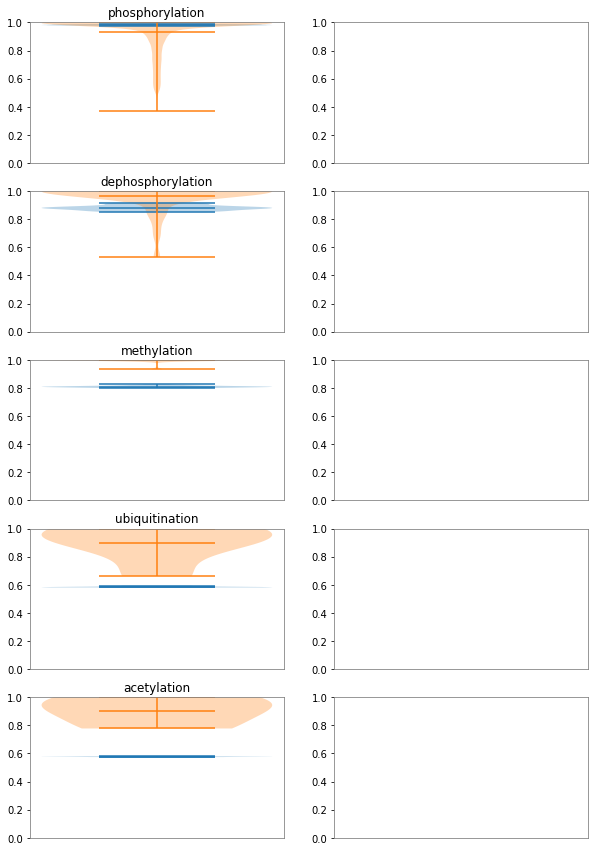

In [12]:
def prep_data(df):
    df_t = df.copy(deep=True)
    pred_class, pred_prob = m.predict(df["x"])
    df_t["nb_pred"] = pred_class
    df_t["nb_pred_conf"] = pred_prob
    df_t["nb_pred_raw"] = df_t["nb_pred"].apply(lambda i: label_names[i])
    return df_t

def plot_confidence(df_t):
    labels =  list(df_t["y_raw"].unique())   
    print(labels)
    _ , ax = plt.subplots(len(labels),2, figsize=(10,15))



    for i,l in enumerate(labels):
        t = df_t.query(f"y_raw == '{l}'")

        for c in range(len(ax[i])):
            ax[i,c].set_ylim(0,1)


            ax[i,c].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False)

            ax[i,c].spines['bottom'].set_color('grey')
            ax[i,c].spines['top'].set_color('grey') 
            ax[i,c].spines['right'].set_color('grey')
            ax[i,c].spines['left'].set_color('grey')



        ax[i,0].violinplot(t["confidence"],  showmeans=True )
        ax[i,0].set_title(f"{l}")


        ax[i,0].violinplot(t["nb_pred_conf"],  showmeans=True )    
       # ax[i,1].set_title(f"Naive Bayes {l}")

plot_confidence(prep_data(df_largescale_hq))

plt.show()




['acetylation', 'methylation', 'phosphorylation', 'ubiquitination', 'dephosphorylation', 'deubiquitination']


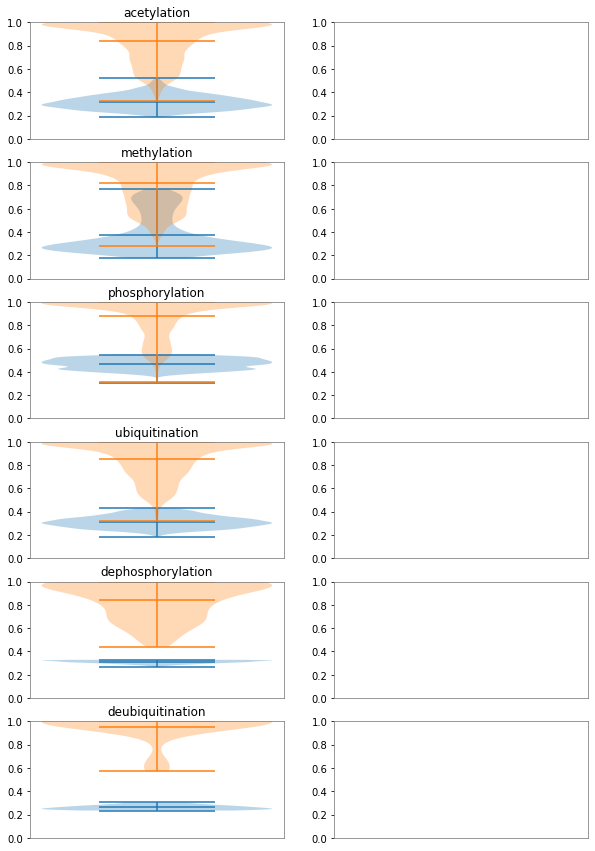

In [13]:
df_low_quality = pd.read_json(largescale_low_hq,orient="records")
df_low_quality["y_raw"] = df_low_quality["prediction"]
df_low_quality["y"] = df_low_quality["prediction"].apply(lambda x: label_names.index(x))

plot_confidence(prep_data(df_low_quality))
plt.show()



In [14]:
df_low_quality.groupby("y_raw")["confidence"].describe()

,count,mean,std,min,25%,50%,75%,max
y_raw,,,,,,,,
acetylation,1430.0,0.315932,0.061691,0.184136,0.270047,0.308719,0.355794,0.520076
dephosphorylation,106.0,0.310715,0.013916,0.265229,0.302265,0.313535,0.322941,0.327856
deubiquitination,18.0,0.260276,0.020266,0.234256,0.246893,0.254616,0.272848,0.303223
methylation,1758.0,0.374698,0.162310,0.177951,0.256256,0.305350,0.457266,0.768542
phosphorylation,1674.0,0.467763,0.046010,0.304020,0.429791,0.471121,0.505772,0.548046
ubiquitination,1696.0,0.312426,0.051377,0.186330,0.273639,0.308847,0.348236,0.428919


In [15]:
prep_data(df_low_quality).groupby("nb_pred_raw")["nb_pred_conf"].describe()

,count,mean,std,min,25%,50%,75%,max
nb_pred_raw,,,,,,,,
acetylation,157.0,0.858839,0.171895,0.361967,0.773876,0.935557,0.999105,1.000000
dephosphorylation,342.0,0.803292,0.182389,0.348857,0.669089,0.854607,0.971741,1.000000
deubiquitination,37.0,0.768200,0.208072,0.357615,0.591312,0.797536,0.948844,0.999992
methylation,425.0,0.852448,0.178592,0.276977,0.723216,0.941263,0.998738,1.000000
other,1655.0,0.782445,0.165351,0.305309,0.644896,0.806595,0.934894,1.000000
phosphorylation,4000.0,0.883803,0.150518,0.342914,0.810284,0.960440,0.996733,1.000000
ubiquitination,66.0,0.804385,0.211922,0.311874,0.664730,0.916823,0.988577,1.000000


In [16]:
print_report(df_low_quality["y"], m.predict(df_low_quality["x"])[0])



              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.30      0.72      0.43      1674
           2       0.02      0.07      0.03       106
           3       0.52      0.13      0.20      1758
           4       0.45      0.02      0.03      1696
           5       0.80      0.09      0.16      1430
           6       0.00      0.00      0.00        18

    accuracy                           0.24      6682
   macro avg       0.30      0.15      0.12      6682
weighted avg       0.50      0.24      0.20      6682



,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,0.303000,0.724014,0.427212,1674.000000
2,0.020468,0.066038,0.031250,106.000000
3,0.517647,0.125142,0.201557,1758.000000
4,0.454545,0.017689,0.034052,1696.000000
5,0.802548,0.088112,0.158790,1430.000000
6,0.000000,0.000000,0.000000,18.000000
accuracy,0.238701,0.238701,0.238701,0.238701
macro avg,0.299744,0.145856,0.121837,6682.000000
weighted avg,0.499546,0.238701,0.203177,6682.000000


In [17]:
prep_data(df_low_quality).query("nb_pred_raw=='phosphorylation' and y_raw=='acetylation'")\
.sort_values(by = ["nb_pred_conf", "confidence"], ascending=False)\
[["x", "nb_pred_conf", "confidence"]].head(n=10)

,x,nb_pred_conf,confidence
6635,Nucleosome remodeling and covalent modificatio...,1.000000,0.289353
6066,PROTPART0 (PROTPART0) is an essential enzyme i...,1.000000,0.302100
5096,The down-regulation of PROTPART1/PROTPART1 gen...,1.000000,0.312728
4211,"The two histone deacetylases (Hdacs), PROTPART...",1.000000,0.312780
1944,"The NatB complex, PROTPART1/PROTPART0 acetyltr...",1.000000,0.299525
3512,N--Acetyltransferase 10 protein (PROTPART1/PRO...,1.000000,0.407942
3520,"The human PRTIG0-PROTPART0 complex, cotranslat...",1.000000,0.309216
4692,Binge alcohol drinking induces hepatic steatos...,0.999999,0.297246
4194,Myeloid-derived suppressor cells (MDSCs) are a...,0.999998,0.309611
4513,Resistance to cytotoxic chemotherapy drugs rem...,0.999997,0.218033


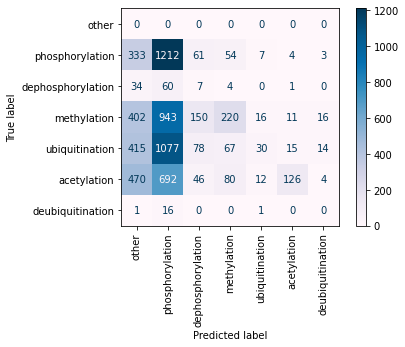

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df_low_quality["y"], m.predict(df_low_quality["x"])[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = label_names)

disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(df_largescale_hq["y"], m.predict(df_largescale_hq["x"])[0])

0.8852260959613393

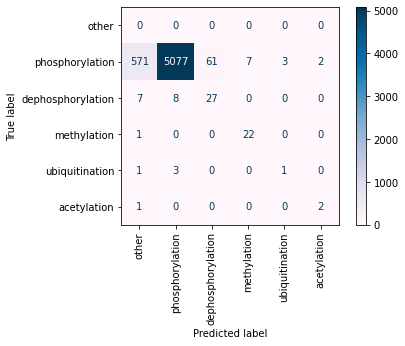

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df_largescale_hq["y"], m.predict(df_largescale_hq["x"])[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = label_names[:6])
disp.plot(cmap="PuBu", xticks_rotation="vertical")

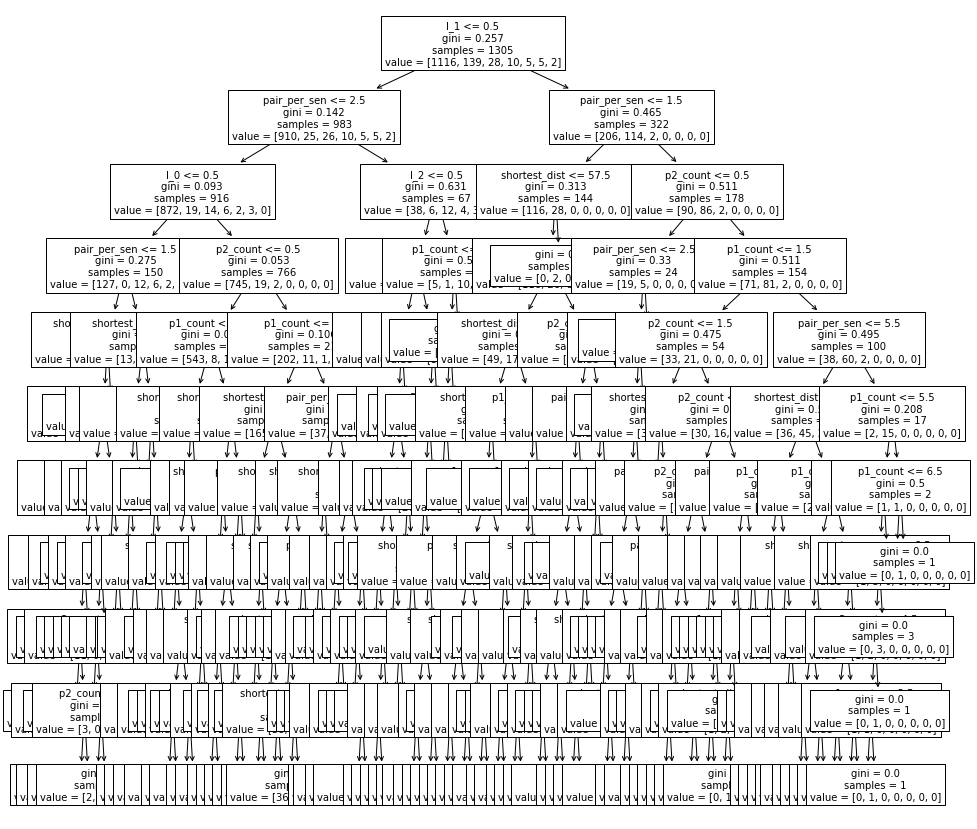

In [22]:
_, ax = plt.subplots(1,1, figsize=(15,15))

tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

plt.show()

